# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3555328/11490434 [========>.....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:06 - loss: 0.6944

  30/1875 [..............................] - ETA: 3s - loss: 0.5462   

  61/1875 [..............................] - ETA: 3s - loss: 0.4641

  92/1875 [>.............................] - ETA: 3s - loss: 0.4219

 123/1875 [>.............................] - ETA: 2s - loss: 0.3948

 158/1875 [=>............................] - ETA: 2s - loss: 0.3730

 193/1875 [==>...........................] - ETA: 2s - loss: 0.3564

 230/1875 [==>...........................] - ETA: 2s - loss: 0.3423

 265/1875 [===>..........................] - ETA: 2s - loss: 0.3311

 304/1875 [===>..........................] - ETA: 2s - loss: 0.3206

 336/1875 [====>.........................] - ETA: 2s - loss: 0.3131

 364/1875 [====>.........................] - ETA: 2s - loss: 0.3071

 395/1875 [=====>........................] - ETA: 2s - loss: 0.3011

 426/1875 [=====>........................] - ETA: 2s - loss: 0.2957

 458/1875 [======>.......................] - ETA: 2s - loss: 0.2905

 490/1875 [======>.......................] - ETA: 2s - loss: 0.2857

 527/1875 [=======>......................] - ETA: 2s - loss: 0.2806

 554/1875 [=======>......................] - ETA: 2s - loss: 0.2772

 585/1875 [========>.....................] - ETA: 2s - loss: 0.2735

 613/1875 [========>.....................] - ETA: 1s - loss: 0.2703

 640/1875 [=========>....................] - ETA: 1s - loss: 0.2674

 665/1875 [=========>....................] - ETA: 1s - loss: 0.2649

 698/1875 [==========>...................] - ETA: 1s - loss: 0.2617

 726/1875 [==========>...................] - ETA: 1s - loss: 0.2591

 758/1875 [===========>..................] - ETA: 1s - loss: 0.2563

 787/1875 [===========>..................] - ETA: 1s - loss: 0.2539

 819/1875 [============>.................] - ETA: 1s - loss: 0.2513

 843/1875 [============>.................] - ETA: 1s - loss: 0.2495

 869/1875 [============>.................] - ETA: 1s - loss: 0.2476

 896/1875 [=============>................] - ETA: 1s - loss: 0.2456

 924/1875 [=============>................] - ETA: 1s - loss: 0.2437

 948/1875 [==============>...............] - ETA: 1s - loss: 0.2421

 973/1875 [==============>...............] - ETA: 1s - loss: 0.2405

1001/1875 [===============>..............] - ETA: 1s - loss: 0.2388

1026/1875 [===============>..............] - ETA: 1s - loss: 0.2373

1050/1875 [===============>..............] - ETA: 1s - loss: 0.2359

1075/1875 [================>.............] - ETA: 1s - loss: 0.2344

1101/1875 [================>.............] - ETA: 1s - loss: 0.2330

1127/1875 [=================>............] - ETA: 1s - loss: 0.2316

1153/1875 [=================>............] - ETA: 1s - loss: 0.2302

1185/1875 [=================>............] - ETA: 1s - loss: 0.2286

1215/1875 [==================>...........] - ETA: 1s - loss: 0.2271

1247/1875 [==================>...........] - ETA: 1s - loss: 0.2256

1277/1875 [===================>..........] - ETA: 1s - loss: 0.2242

1305/1875 [===================>..........] - ETA: 0s - loss: 0.2230

1336/1875 [====================>.........] - ETA: 0s - loss: 0.2216

1365/1875 [====================>.........] - ETA: 0s - loss: 0.2204

1396/1875 [=====================>........] - ETA: 0s - loss: 0.2191

1425/1875 [=====================>........] - ETA: 0s - loss: 0.2179

1457/1875 [======================>.......] - ETA: 0s - loss: 0.2166

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1513/1875 [=======================>......] - ETA: 0s - loss: 0.2145

1542/1875 [=======================>......] - ETA: 0s - loss: 0.2135

1574/1875 [========================>.....] - ETA: 0s - loss: 0.2123

1601/1875 [========================>.....] - ETA: 0s - loss: 0.2114

1626/1875 [=========================>....] - ETA: 0s - loss: 0.2105

1653/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1680/1875 [=========================>....] - ETA: 0s - loss: 0.2087

1708/1875 [==========================>...] - ETA: 0s - loss: 0.2078

1733/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1760/1875 [===========================>..] - ETA: 0s - loss: 0.2062

1788/1875 [===========================>..] - ETA: 0s - loss: 0.2054

1816/1875 [============================>.] - ETA: 0s - loss: 0.2045

1847/1875 [============================>.] - ETA: 0s - loss: 0.2036

1875/1875 [==============================] - ETA: 0s - loss: 0.2028

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2028


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0967

  31/1875 [..............................] - ETA: 3s - loss: 0.1061

  58/1875 [..............................] - ETA: 3s - loss: 0.1070

  88/1875 [>.............................] - ETA: 3s - loss: 0.1076

 119/1875 [>.............................] - ETA: 3s - loss: 0.1079

 151/1875 [=>............................] - ETA: 2s - loss: 0.1082

 183/1875 [=>............................] - ETA: 2s - loss: 0.1083

 216/1875 [==>...........................] - ETA: 2s - loss: 0.1084

 248/1875 [==>...........................] - ETA: 2s - loss: 0.1084

 280/1875 [===>..........................] - ETA: 2s - loss: 0.1084

 308/1875 [===>..........................] - ETA: 2s - loss: 0.1084

 340/1875 [====>.........................] - ETA: 2s - loss: 0.1084

 365/1875 [====>.........................] - ETA: 2s - loss: 0.1083

 394/1875 [=====>........................] - ETA: 2s - loss: 0.1083

 421/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 451/1875 [======>.......................] - ETA: 2s - loss: 0.1082

 482/1875 [======>.......................] - ETA: 2s - loss: 0.1081

 509/1875 [=======>......................] - ETA: 2s - loss: 0.1081

 539/1875 [=======>......................] - ETA: 2s - loss: 0.1080

 563/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 591/1875 [========>.....................] - ETA: 2s - loss: 0.1079

 625/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 654/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 685/1875 [=========>....................] - ETA: 2s - loss: 0.1077

 710/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 738/1875 [==========>...................] - ETA: 1s - loss: 0.1076

 765/1875 [===========>..................] - ETA: 1s - loss: 0.1076

 793/1875 [===========>..................] - ETA: 1s - loss: 0.1075

 813/1875 [============>.................] - ETA: 1s - loss: 0.1074

 844/1875 [============>.................] - ETA: 1s - loss: 0.1074

 875/1875 [=============>................] - ETA: 1s - loss: 0.1073

 908/1875 [=============>................] - ETA: 1s - loss: 0.1072

 939/1875 [==============>...............] - ETA: 1s - loss: 0.1072

 972/1875 [==============>...............] - ETA: 1s - loss: 0.1071

1004/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1037/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1070/1875 [================>.............] - ETA: 1s - loss: 0.1069

1103/1875 [================>.............] - ETA: 1s - loss: 0.1068

1136/1875 [=================>............] - ETA: 1s - loss: 0.1067

1169/1875 [=================>............] - ETA: 1s - loss: 0.1067

1202/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1235/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1267/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1296/1875 [===================>..........] - ETA: 0s - loss: 0.1064

1329/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1362/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1395/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1428/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1460/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1493/1875 [======================>.......] - ETA: 0s - loss: 0.1060

1526/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1559/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1591/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1657/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1690/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1720/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1749/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1776/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1806/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1833/1875 [============================>.] - ETA: 0s - loss: 0.1055

1864/1875 [============================>.] - ETA: 0s - loss: 0.1054

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1054


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0995

  32/1875 [..............................] - ETA: 3s - loss: 0.0969

  63/1875 [>.............................] - ETA: 2s - loss: 0.0969

  93/1875 [>.............................] - ETA: 2s - loss: 0.0968

 124/1875 [>.............................] - ETA: 2s - loss: 0.0967

 155/1875 [=>............................] - ETA: 2s - loss: 0.0967

 186/1875 [=>............................] - ETA: 2s - loss: 0.0968

 216/1875 [==>...........................] - ETA: 2s - loss: 0.0969

 247/1875 [==>...........................] - ETA: 2s - loss: 0.0970

 278/1875 [===>..........................] - ETA: 2s - loss: 0.0970

 310/1875 [===>..........................] - ETA: 2s - loss: 0.0971

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0971

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0972

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0972

 434/1875 [=====>........................] - ETA: 2s - loss: 0.0972

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0972

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0973

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0973

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0973

 589/1875 [========>.....................] - ETA: 2s - loss: 0.0973

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0973

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0973

 681/1875 [=========>....................] - ETA: 1s - loss: 0.0973

 712/1875 [==========>...................] - ETA: 1s - loss: 0.0973

 743/1875 [==========>...................] - ETA: 1s - loss: 0.0973

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0973

 805/1875 [===========>..................] - ETA: 1s - loss: 0.0973

 835/1875 [============>.................] - ETA: 1s - loss: 0.0973

 866/1875 [============>.................] - ETA: 1s - loss: 0.0973

 896/1875 [=============>................] - ETA: 1s - loss: 0.0973

 927/1875 [=============>................] - ETA: 1s - loss: 0.0974

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0974

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0974

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0974

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0974

1081/1875 [================>.............] - ETA: 1s - loss: 0.0974

1112/1875 [================>.............] - ETA: 1s - loss: 0.0974

1142/1875 [=================>............] - ETA: 1s - loss: 0.0974

1173/1875 [=================>............] - ETA: 1s - loss: 0.0974

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0974

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0974

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0974

1287/1875 [===================>..........] - ETA: 0s - loss: 0.0974

1314/1875 [====================>.........] - ETA: 0s - loss: 0.0973

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0973

1369/1875 [====================>.........] - ETA: 0s - loss: 0.0973

1399/1875 [=====================>........] - ETA: 0s - loss: 0.0973

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0973

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0973

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0973

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1548/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1824/1875 [============================>.] - ETA: 0s - loss: 0.0973

1852/1875 [============================>.] - ETA: 0s - loss: 0.0973

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0973


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0980

  28/1875 [..............................] - ETA: 3s - loss: 0.0974

  56/1875 [..............................] - ETA: 3s - loss: 0.0970

  81/1875 [>.............................] - ETA: 3s - loss: 0.0966

 110/1875 [>.............................] - ETA: 3s - loss: 0.0964

 142/1875 [=>............................] - ETA: 3s - loss: 0.0963

 173/1875 [=>............................] - ETA: 3s - loss: 0.0963

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 236/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 267/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 298/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 329/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 391/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 422/1875 [=====>........................] - ETA: 2s - loss: 0.0961

 453/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 484/1875 [======>.......................] - ETA: 2s - loss: 0.0961

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0961

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 604/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 632/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 660/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 718/1875 [==========>...................] - ETA: 1s - loss: 0.0960

 747/1875 [==========>...................] - ETA: 1s - loss: 0.0960

 776/1875 [===========>..................] - ETA: 1s - loss: 0.0960

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0960

 830/1875 [============>.................] - ETA: 1s - loss: 0.0960

 858/1875 [============>.................] - ETA: 1s - loss: 0.0960

 888/1875 [=============>................] - ETA: 1s - loss: 0.0960

 918/1875 [=============>................] - ETA: 1s - loss: 0.0960

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1036/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1066/1875 [================>.............] - ETA: 1s - loss: 0.0960

1095/1875 [================>.............] - ETA: 1s - loss: 0.0960

1123/1875 [================>.............] - ETA: 1s - loss: 0.0960

1152/1875 [=================>............] - ETA: 1s - loss: 0.0960

1183/1875 [=================>............] - ETA: 1s - loss: 0.0960

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1306/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1337/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1367/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1423/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1454/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1831/1875 [============================>.] - ETA: 0s - loss: 0.0959

1861/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0934

  31/1875 [..............................] - ETA: 3s - loss: 0.0954

  62/1875 [..............................] - ETA: 3s - loss: 0.0958

  92/1875 [>.............................] - ETA: 2s - loss: 0.0959

 122/1875 [>.............................] - ETA: 2s - loss: 0.0958

 153/1875 [=>............................] - ETA: 2s - loss: 0.0958

 183/1875 [=>............................] - ETA: 2s - loss: 0.0957

 214/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 244/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 305/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 333/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0957

 388/1875 [=====>........................] - ETA: 2s - loss: 0.0957

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0957

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 473/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 661/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 691/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 723/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 753/1875 [===========>..................] - ETA: 1s - loss: 0.0955

 783/1875 [===========>..................] - ETA: 1s - loss: 0.0955

 814/1875 [============>.................] - ETA: 1s - loss: 0.0955

 844/1875 [============>.................] - ETA: 1s - loss: 0.0955

 874/1875 [============>.................] - ETA: 1s - loss: 0.0955

 905/1875 [=============>................] - ETA: 1s - loss: 0.0955

 936/1875 [=============>................] - ETA: 1s - loss: 0.0955

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1083/1875 [================>.............] - ETA: 1s - loss: 0.0955

1114/1875 [================>.............] - ETA: 1s - loss: 0.0955

1144/1875 [=================>............] - ETA: 1s - loss: 0.0955

1174/1875 [=================>............] - ETA: 1s - loss: 0.0955

1205/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1298/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1359/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1834/1875 [============================>.] - ETA: 0s - loss: 0.0954

1860/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

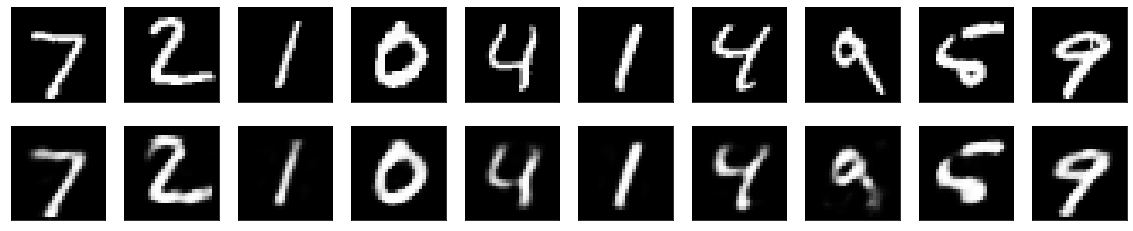

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
